This notebook focuses on image processing and machine learning for skin cancer classification. Below is a description of the main components:
OpenCV and other libraries are used  to load and preprocess images for analysis.

DATASET: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
### **1.   Image procesing techniques:**

The notebook demonstrates the calculation of RGB histograms and different histogram manipulation techniques (stretching, equalization, normalization).

The effects of these techniques on image appearance are visualized.
Median and Gaussian filtering are applied to images.
Erosion and dilation operations are demonstrated.
Various thresholding techniques (global, local, adaptive) are applied, and their effects are displayed.Sobel, Laplace, and Canny edge detection techniques are applied to images. Contours are extracted using Canny, and morphological operations are applied.

K-Means clustering is applied to segment the image into k clusters.
The segmented result is visualized alongside the original image.
Conclusion:

### **2.   Machine learning clasification model (SVM)**

A function extract_features is defined to extract various features from skin cancer images, including color statistics, gradient properties, concentric properties, symmetry, and others.
The extracted features are then used for further analysis.
Data Analysis and Visualization:

The notebook processes the images in the specified folders (train and test) and extracts features for each image.
Features are stored in CSV files for later use.
Dataframes are created from these CSV files for exploratory data analysis (EDA).
Correlation matrices and pair plots are used to visualize relationships between different features.
PCA is applied to reduce the dimensionality of the color features, creating a new feature called 'pca_color'.
The correlation matrix is visualized after PCA.

Skin cancer classification is performed using a Support Vector Machine (SVM) model.
The model is trained on the training set and evaluated on the test set.
Classification metrics (accuracy, confusion matrix, etc.) are displayed.


In [1]:
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import pandas as pd
import seaborn as sns
from ast import literal_eval
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def extract_features(image):
    # Grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Median filtration
    median_filtered = cv2.medianBlur(gray_image, 5)

    # Ditalation
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(median_filtered, kernel, iterations=1)

    # Image scaling
    min_val, max_val, _, _ = cv2.minMaxLoc(dilation)
    stretched_image = cv2.convertScaleAbs(dilation, alpha=255.0/(max_val-min_val), beta=-min_val*(255.0/(max_val-min_val)))

    # Binarization
    adaptive_thresholded = cv2.threshold(stretched_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    canny = cv2.Canny(adaptive_thresholded, 50, 150)

    #Contoutrs
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []

    num_contours = len(contours)

    # Approximate the contour of the entire image using the Ramer-Douglas-Peucker method.
    epsilon = 0.02 * cv2.arcLength(np.concatenate(contours), True)
    approx = cv2.approxPolyDP(np.concatenate(contours), epsilon, True)

    x, y, w, h = cv2.boundingRect(np.concatenate(contours))
    aspect_ratio = float(w) / h

    # Color: Average color of the region identified by the contour.
    mean_color = np.mean(image[y:y+h, x:x+w], axis=(0, 1))

    # Gradient properties: Image gradient analysis.
    gradient_magnitude, gradient_angle = cv2.cartToPolar(cv2.Sobel(gray_image, cv2.CV_64F, 1, 0), cv2.Sobel(gray_image, cv2.CV_64F, 0, 1))
    mean_gradient_magnitude = np.mean(gradient_magnitude[y:y+h, x:x+w])

    #Concentric properties.
    moments = cv2.moments(np.concatenate(contours))
    if moments['mu20'] + moments['mu02'] != 0:
        eccentricity = ((moments['mu20'] - moments['mu02'])**2 + 4 * moments['mu11']**2)**0.5 / (moments['mu20'] + moments['mu02'])
        elongation = (moments['mu20'] + moments['mu02'] + np.sqrt((moments['mu20'] - moments['mu02'])**2 + 4 * moments['mu11']**2)) / \
                  (moments['mu20'] + moments['mu02'] - np.sqrt((moments['mu20'] - moments['mu02'])**2 + 4 * moments['mu11']**2))
    else:
        eccentricity = 0
        elongation = 0


    # Symmetry: Measures how symmetrical the skin region is.
    symmetry = cv2.matchShapes(np.concatenate(contours), approx, cv2.CONTOURS_MATCH_I2, 0.0)


    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = hist / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-10))

    area = cv2.contourArea(contours[0])
    perimeter = cv2.arcLength(contours[0], True)
    if perimeter != 0:
      circularity = (4 * np.pi * area) / (perimeter**2)
    else:
      circularity = 0

    features.append({
            'mean_color': mean_color,
            'perimeter': perimeter,
            'mean_gradient_magnitude': mean_gradient_magnitude,
            'num_vertices': len(approx),
            'num_contours': num_contours,
            'entropy': entropy,
        })

    return adaptive_thresholded, features


In [4]:
train_folder = '/content/drive/My Drive/skin-cancer-malignant-vs-benign/train'
test_folder = '/content/drive/My Drive/skin-cancer-malignant-vs-benign/test'

def process_images_and_save_csv(folder_path, output_csv):

    with open(output_csv, 'w', newline='') as csvfile:

        fieldnames = [
            'mean_color',
            'mean_gradient_magnitude',
            'num_vertices',
            'num_contours',
            'entropy',
            'perimeter',
            'class']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()

        for class_name in os.listdir(folder_path):
            class_folder = os.path.join(folder_path, class_name)

            for filename in os.listdir(class_folder):
                image_path = os.path.join(class_folder, filename)

                image = cv2.imread(image_path)

                result_image, features = extract_features(image)

                for feature in features:
                    feature['class'] = class_name
                    writer.writerow(feature)

In [5]:
process_images_and_save_csv(train_folder, '/content/drive/My Drive/skin-cancer-malignant-vs-benign/train_features.csv')

process_images_and_save_csv(test_folder, '/content/drive/My Drive/skin-cancer-malignant-vs-benign/test_features.csv')

In [6]:

train_df = pd.read_csv('/content/drive/My Drive/skin-cancer-malignant-vs-benign/train_features.csv')
test_df = pd.read_csv('/content/drive/My Drive/skin-cancer-malignant-vs-benign/test_features.csv')


combined_df = pd.concat([train_df, test_df], ignore_index=True)

combined_df['mean_color'] = combined_df['mean_color'].apply(lambda x: list(map(float, x[1:-1].split())))
combined_df[['mean_color_R', 'mean_color_G', 'mean_color_B']] = pd.DataFrame(combined_df['mean_color'].tolist(), index=combined_df.index)

combined_df = combined_df.drop('mean_color', axis=1)

print(combined_df.head())


   mean_gradient_magnitude  num_vertices  num_contours   entropy   perimeter  \
0                28.652760            11             2  6.379942  534.901584   
1                50.549897             7             1  5.197154  127.982755   
2                55.541880             8            36  6.534026   57.899495   
3                24.156079             8            43  5.382496    5.656854   
4                21.383199            14             3  6.589223  540.416300   

    class  mean_color_R  mean_color_G  mean_color_B  
0  benign    157.934333    157.752176    201.165600  
1  benign     72.855556     88.896528    188.162500  
2  benign     94.877299     87.975688    182.028649  
3  benign    131.111308    127.792012    199.989696  
4  benign     69.676722     74.443441    181.310071  


<ipython-input-7-8a64484157ee>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = combined_df.corr()


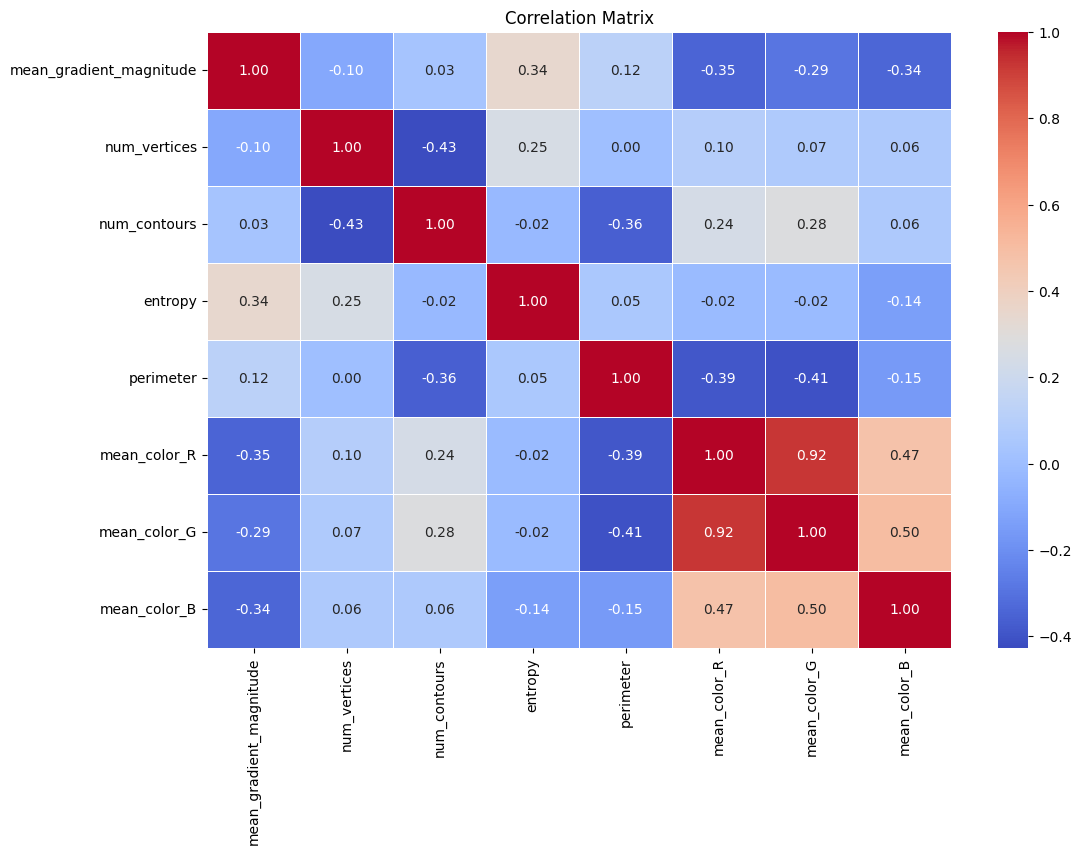

In [7]:
correlation_matrix = combined_df.corr()


plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title("Correlation Matrix")

plt.show()

In [8]:
pca = PCA(n_components=1)
combined_df['pca_color'] = pca.fit_transform(combined_df[['mean_color_R', 'mean_color_G', 'mean_color_B']])
combined_df = combined_df.drop(['mean_color_R', 'mean_color_G', 'mean_color_B'], axis=1)

<ipython-input-9-b1c41fda82b5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = combined_df.corr()


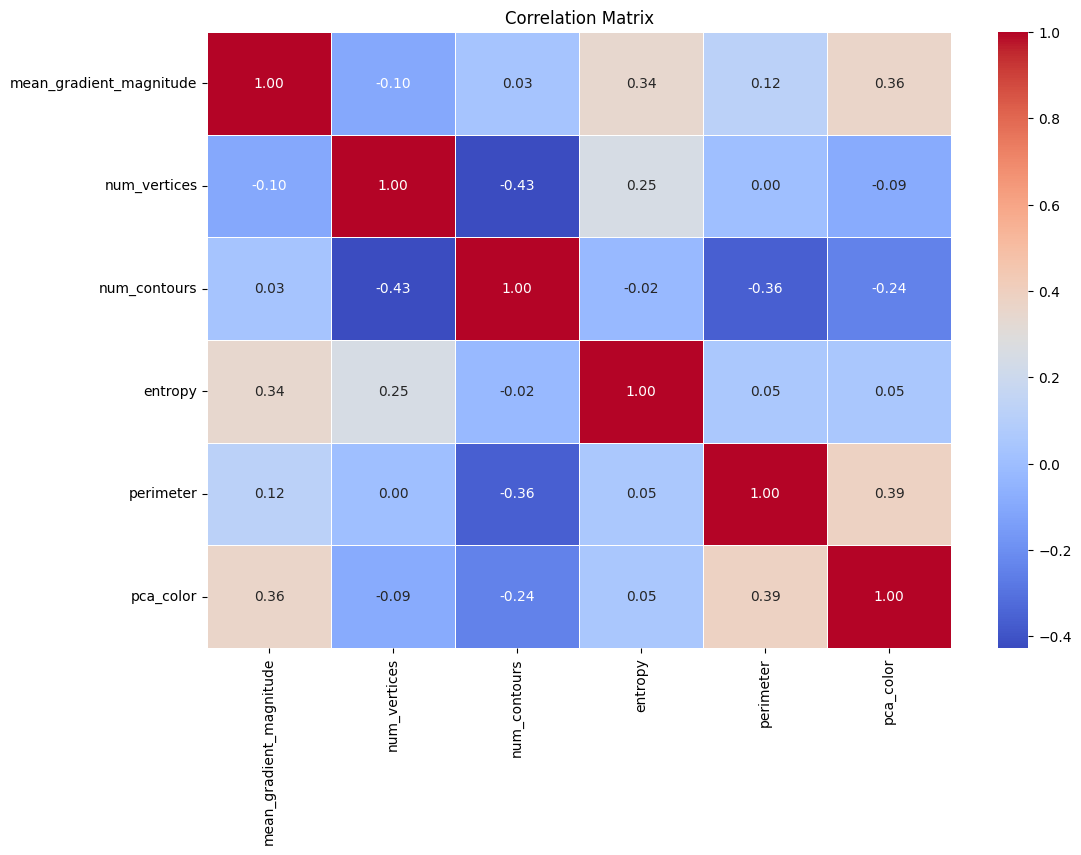

In [9]:
correlation_matrix = combined_df.corr()


plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)


plt.title("Correlation Matrix")


plt.show()

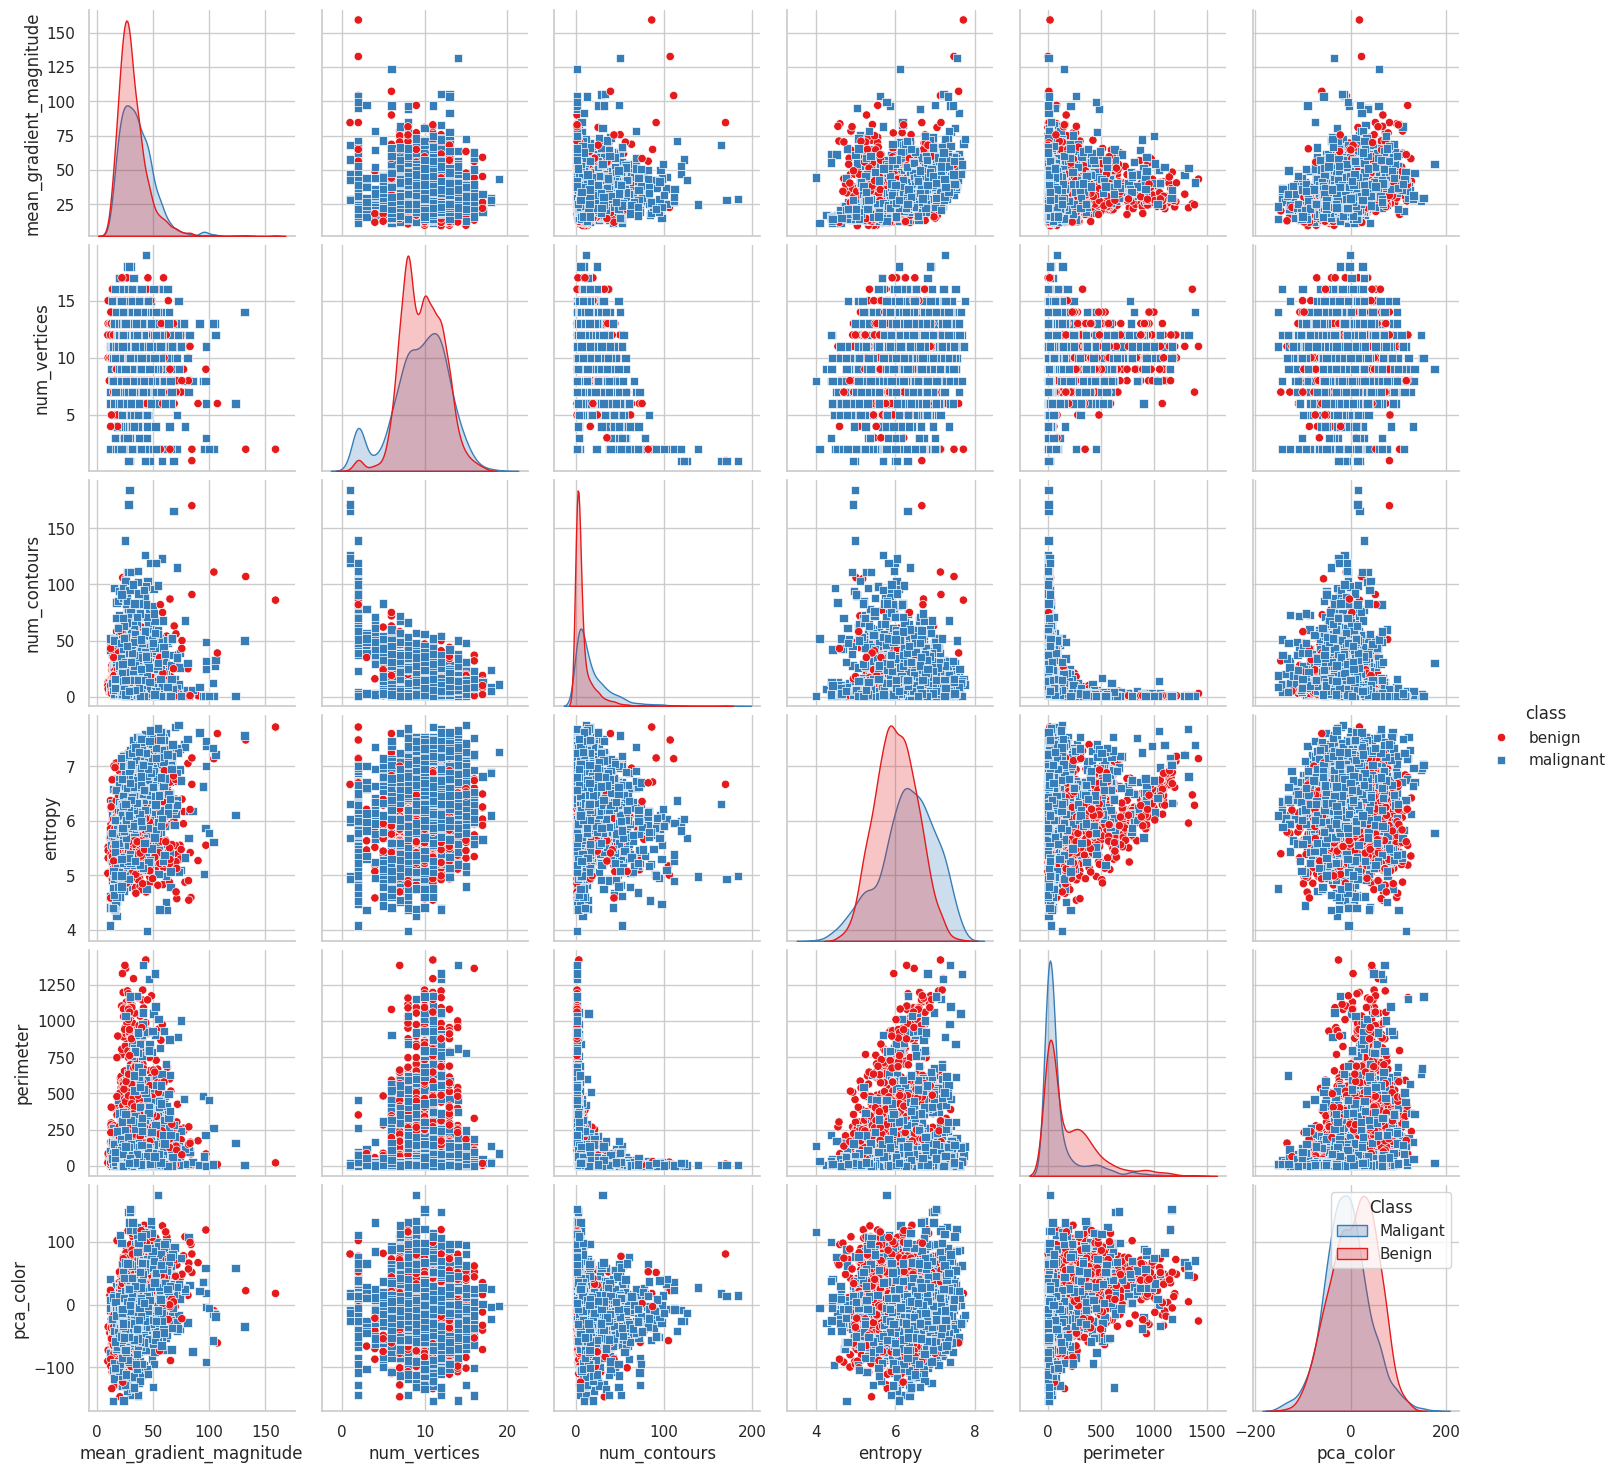

In [10]:
sns.set(style="whitegrid")

sns.pairplot(combined_df, hue='class', markers=['o', 's'], palette='Set1')

plt.legend(title='Class', loc='upper right', labels=['Maligant', 'Benign'])

plt.show()

In [11]:
train_df = pd.read_csv('/content/drive/My Drive/skin-cancer-malignant-vs-benign/train_features.csv')
test_df = pd.read_csv('/content/drive/My Drive/skin-cancer-malignant-vs-benign/test_features.csv')


train_df = pd.read_csv('/content/drive/My Drive/skin-cancer-malignant-vs-benign/train_features.csv')
test_df = pd.read_csv('/content/drive/My Drive/skin-cancer-malignant-vs-benign/test_features.csv')

train_df['mean_color'] = train_df['mean_color'].apply(lambda x: list(map(float, x[1:-1].split())))
test_df['mean_color'] = test_df['mean_color'].apply(lambda x: list(map(float, x[1:-1].split())))

train_df[['mean_color_R', 'mean_color_G', 'mean_color_B']] = pd.DataFrame(train_df['mean_color'].tolist(), index=train_df.index)
test_df[['mean_color_R', 'mean_color_G', 'mean_color_B']] = pd.DataFrame(test_df['mean_color'].tolist(), index=test_df.index)

train_df = train_df.drop('mean_color', axis=1)
test_df = test_df.drop('mean_color', axis=1)

X_train = train_df.drop('class', axis=1)
y_train = train_df['class']

X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

pca = PCA(n_components=1)
X_train['pca_color'] = pca.fit_transform(X_train[['mean_color_R', 'mean_color_G', 'mean_color_B']])
X_train = X_train.drop(['mean_color_R', 'mean_color_G', 'mean_color_B'], axis=1)

X_test['pca_color'] = pca.transform(X_test[['mean_color_R', 'mean_color_G', 'mean_color_B']])
X_test = X_test.drop(['mean_color_R', 'mean_color_G', 'mean_color_B'], axis=1)

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(C=1, gamma='auto', kernel='rbf', random_state=42)

svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set: {accuracy:.2f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy on test set: 0.75

Classification Report:
              precision    recall  f1-score   support

      benign       0.79      0.75      0.77       360
   malignant       0.72      0.76      0.74       300

    accuracy                           0.75       660
   macro avg       0.75      0.75      0.75       660
weighted avg       0.75      0.75      0.75       660


Confusion Matrix:
[[270  90]
 [ 73 227]]


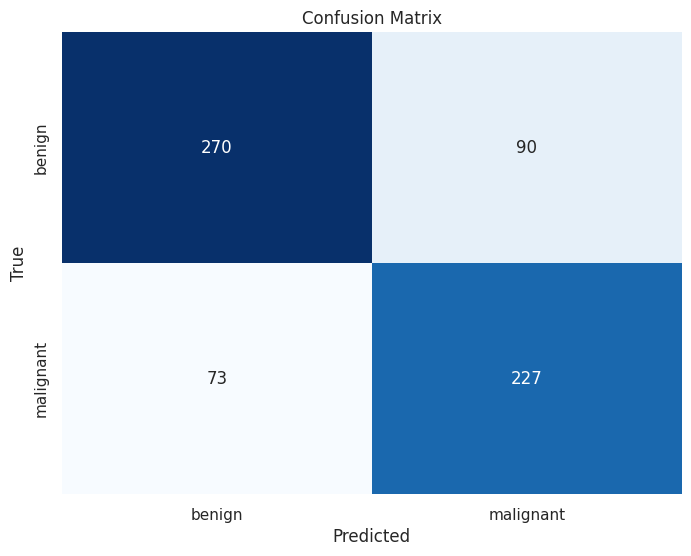

In [13]:
cm = confusion_matrix(y_test, y_pred)

class_names = svm_model.classes_

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

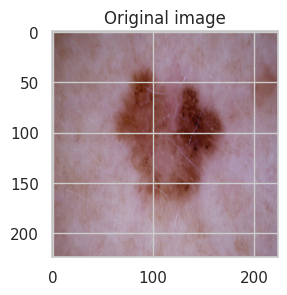

In [14]:
image = cv2.imread('/content/drive/My Drive/skin-cancer-malignant-vs-benign/train/malignant/1490.jpg')
image2 = cv2.imread('/content/drive/My Drive/skin-cancer-malignant-vs-benign/train/malignant/1490.jpg')
# Sprawdź, czy obraz został poprawnie wczytany
if image is not None:
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original image')
else:
    print('Failed to load the image')

In [15]:
blue_channel, green_channel, red_channel = cv2.split(image)

In [16]:
hist_blue = cv2.calcHist([blue_channel], [0], None, [256], [0, 256])
hist_green = cv2.calcHist([green_channel], [0], None, [256], [0, 256])
hist_red = cv2.calcHist([red_channel], [0], None, [256], [0, 256])

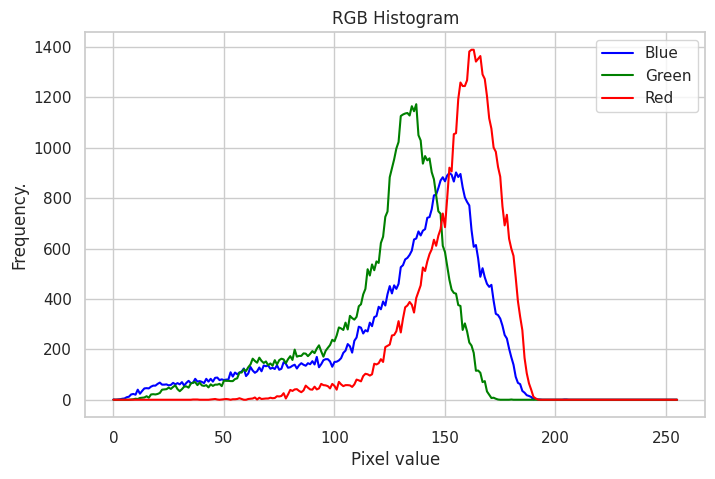

In [17]:
plt.figure(figsize=(8, 5))

plt.plot(hist_blue, color='blue', label='Blue')
plt.plot(hist_green, color='green', label='Green')
plt.plot(hist_red, color='red', label='Red')

plt.title('RGB Histogram')
plt.xlabel('Pixel value')
plt.ylabel('Frequency.')
plt.legend()
plt.show()

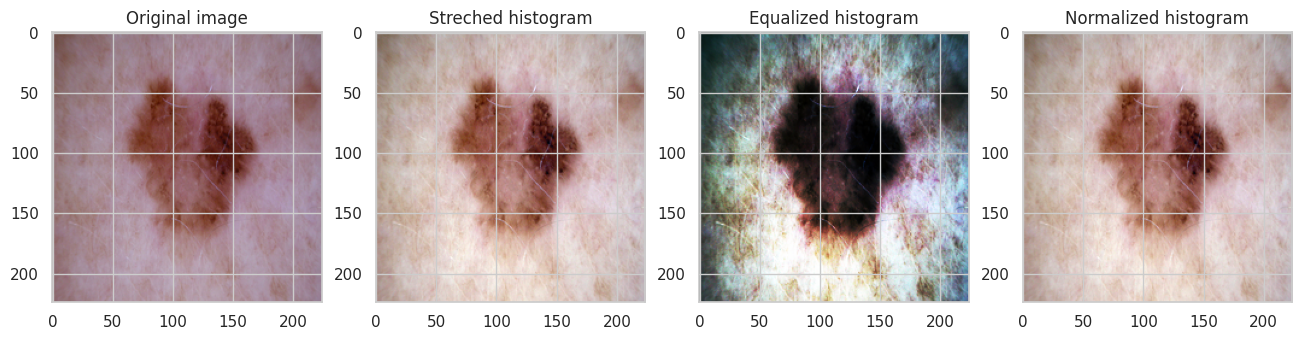

In [18]:
blue_channel, green_channel, red_channel = cv2.split(image)

min_val, max_val, _, _ = cv2.minMaxLoc(blue_channel)
streched_blue = cv2.convertScaleAbs(blue_channel, alpha=255.0/(max_val-min_val), beta=-min_val*(255.0/(max_val-min_val)))

min_val, max_val, _, _ = cv2.minMaxLoc(green_channel)
streched_green = cv2.convertScaleAbs(green_channel, alpha=255.0/(max_val-min_val), beta=-min_val*(255.0/(max_val-min_val)))

min_val, max_val, _, _ = cv2.minMaxLoc(red_channel)
streched_red = cv2.convertScaleAbs(red_channel, alpha=255.0/(max_val-min_val), beta=-min_val*(255.0/(max_val-min_val)))

equalized_blue = cv2.equalizeHist(blue_channel)
equalized_green = cv2.equalizeHist(green_channel)
equalized_red = cv2.equalizeHist(red_channel)

normalized_blue = cv2.normalize(blue_channel, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
normalized_green = cv2.normalize(green_channel, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
normalized_red = cv2.normalize(red_channel, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

_, thresholded_blue = cv2.threshold(blue_channel, 127, 255, cv2.THRESH_BINARY)
_, thresholded_green = cv2.threshold(green_channel, 127, 255, cv2.THRESH_BINARY)
_, thresholded_red = cv2.threshold(red_channel, 127, 255, cv2.THRESH_BINARY)

streched_image = cv2.merge([streched_blue, streched_green, streched_red])
equalized_image = cv2.merge([equalized_blue, equalized_green, equalized_red])
normalized_image = cv2.merge([normalized_blue, normalized_green, normalized_red])
thresholded_image = cv2.merge([thresholded_blue, thresholded_green, thresholded_red])

plt.figure(figsize=(16, 10))

plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original image')

plt.subplot(2, 4, 2)
plt.imshow(cv2.cvtColor(streched_image, cv2.COLOR_BGR2RGB))
plt.title('Streched histogram')

plt.subplot(2, 4, 3)
plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
plt.title('Equalized histogram')

plt.subplot(2, 4, 4)
plt.imshow(cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB))
plt.title('Normalized histogram')

plt.show()

In [19]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

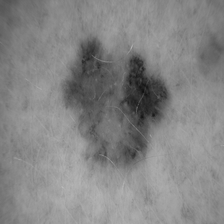

In [20]:
cv2_imshow(gray_image)

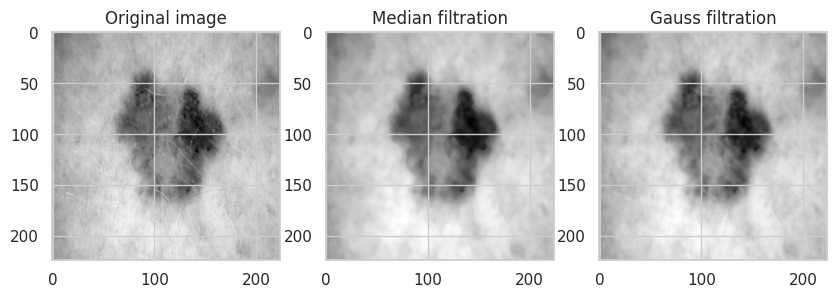

In [21]:
median_filtered = cv2.medianBlur(gray_image, 5)

gaussian_filtered = cv2.GaussianBlur(gray_image, (5, 5), 0)
plt.figure(figsize=(10, 7))


plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(median_filtered, cmap='gray')
plt.title('Median filtration')

plt.subplot(1, 3, 3)
plt.imshow(gaussian_filtered, cmap='gray')
plt.title('Gauss filtration')

plt.show()

gray_image = median_filtered

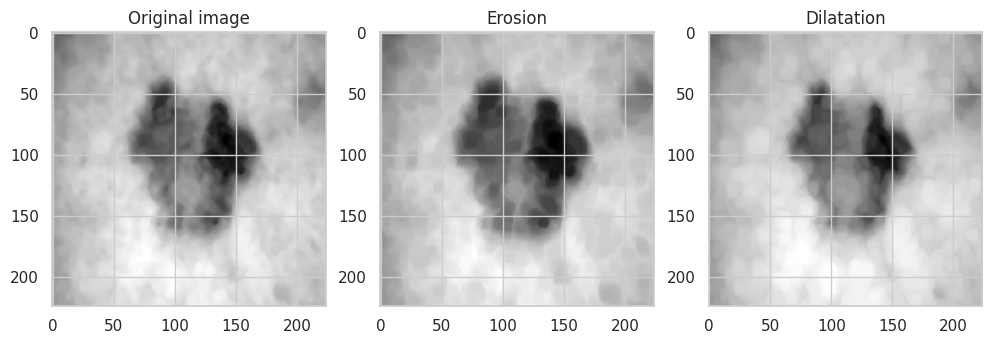

In [22]:
kernel = np.ones((5, 5), np.uint8)

erosion = cv2.erode(gray_image, kernel, iterations=1)

dilation = cv2.dilate(gray_image, kernel, iterations=1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(erosion, cmap='gray')
plt.title('Erosion')

plt.subplot(1, 3, 3)
plt.imshow(dilation, cmap='gray')
plt.title('Dilatation')

plt.show()

gray_image = dilation

In [23]:
hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

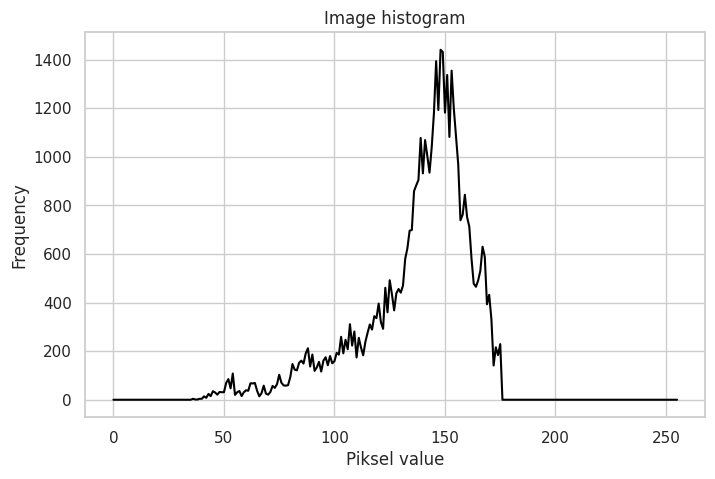

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(hist, color='black')
plt.title('Image histogram')
plt.xlabel('Piksel value')
plt.ylabel('Frequency')
plt.show()

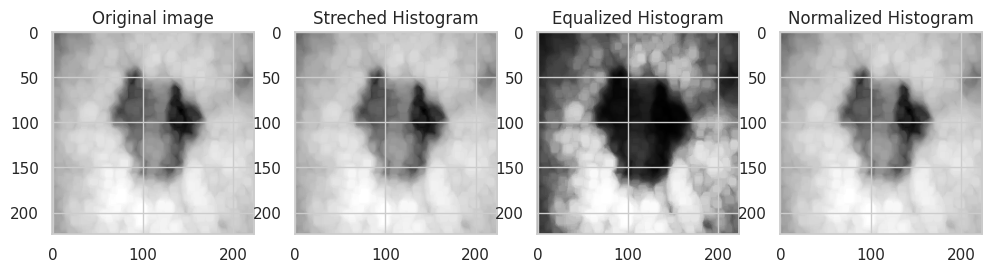

In [25]:
min_val, max_val, _, _ = cv2.minMaxLoc(gray_image)
streched_image = cv2.convertScaleAbs(gray_image, alpha=255.0/(max_val-min_val), beta=-min_val*(255.0/(max_val-min_val)))

equalized_image = cv2.equalizeHist(gray_image)

normalized_image = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

_, thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12, 8))

plt.subplot(2, 4, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original image')

plt.subplot(2, 4, 2)
plt.imshow(streched_image, cmap='gray')
plt.title('Streched Histogram')

plt.subplot(2, 4, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Histogram')

plt.subplot(2, 4, 4)
plt.imshow(normalized_image, cmap='gray')
plt.title('Normalized Histogram')

plt.show()

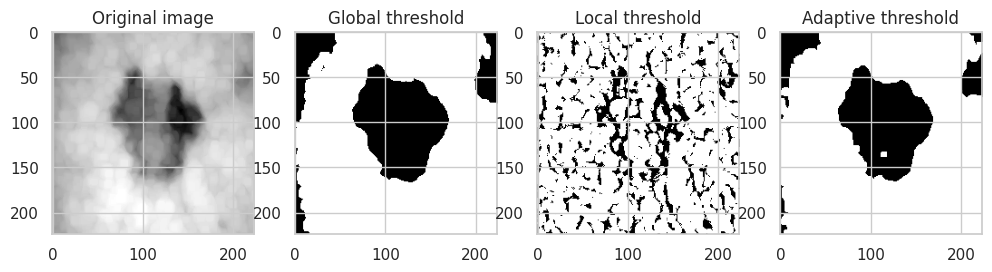

In [26]:
_, global_thresholded = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

block_size = 11
local_thresholded = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, 2)

adaptive_thresholded = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original image')

plt.subplot(1, 4, 2)
plt.imshow(global_thresholded, cmap='gray')
plt.title('Global threshold')

plt.subplot(1, 4, 3)
plt.imshow(local_thresholded, cmap='gray')
plt.title('Local threshold')

plt.subplot(1, 4, 4)
plt.imshow(adaptive_thresholded, cmap='gray')
plt.title('Adaptive threshold')

plt.show()

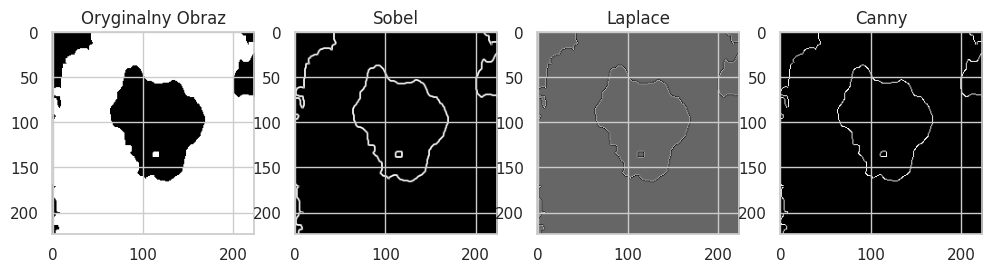

In [27]:
sobel_x = cv2.Sobel(adaptive_thresholded, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(adaptive_thresholded, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)

laplacian = cv2.Laplacian(adaptive_thresholded, cv2.CV_64F)


canny = cv2.Canny(adaptive_thresholded, 50, 150)

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(adaptive_thresholded, cmap='gray')
plt.title('Oryginalny Obraz')

plt.subplot(1, 4, 2)
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel')

plt.subplot(1, 4, 3)
plt.imshow(laplacian, cmap='gray')
plt.title('Laplace')

plt.subplot(1, 4, 4)
plt.imshow(canny, cmap='gray')
plt.title('Canny')

plt.show()

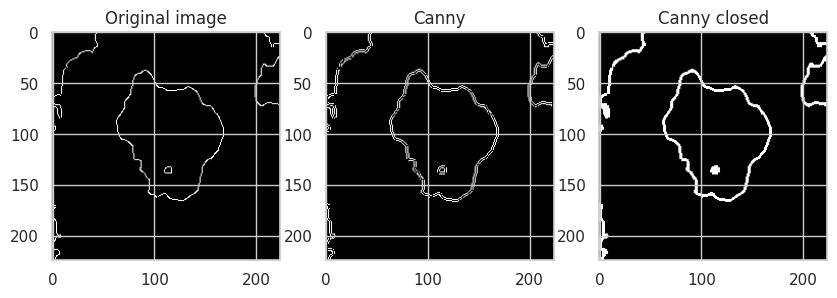

In [28]:
contour_filter = cv2.Canny(canny, 50, 150)

kernel = np.ones((5, 5), np.uint8)
contour_filter_closed = cv2.morphologyEx(contour_filter, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(canny, cmap='gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(contour_filter, cmap='gray')
plt.title('Canny')

plt.subplot(1, 3, 3)
plt.imshow(contour_filter_closed, cmap='gray')
plt.title('Canny closed')

plt.show()

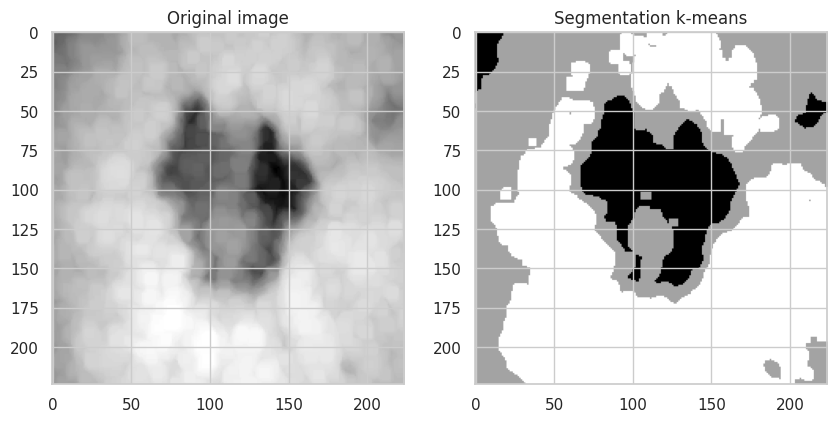

In [29]:
pixels = gray_image.reshape((-1, 1))
pixels = np.float32(pixels)

k = 3

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

segmented_image_gray = centers[labels.flatten()].reshape(gray_image.shape)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original image')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_gray, cmap='gray')
plt.title('Segmentation k-means')

plt.show()